In [1]:
import pickle
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint
from copy import deepcopy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier

np.random.seed(666)

only_obtain_best_models = False

# Loading and parsing data

In [2]:
data = pd.read_csv('./dane_pluca.csv')

# translate to english
data = data.rename(columns={
 'data.urodzenia':                 'date_birth',
 'data.rozpoczecia.leczenia':      'date_start_treatment',
 'data.operacji':                  'date_surgery',
 'zyje':                           'alive',
 'plec':                           'sex',
 'wymiar.guza.x':                  'tumor_size_x',
 'wymiar.guza.y':                  'tumor_size_y',
 'wymiar.guza.z':                  'tumor_size_z',
 'rozpozananie.histopatologiczne': 'histopatological_diagnosis',
 'ile.lat.pali':                   'years_smoking',
 'rodzine.nowotwory.pluc':         'lung_cancer_in_family',
 'objawy.choroby.bol':             'symptoms',
 'stadium.uicc':                   'stadium_uicc',
 'rozpoznanie.wiek':               'age',
 'czas.do.operacji':               'time_to_surgery',
})

data = data.fillna('unknown')

# date variables are transformed to age
def parse_date(date_string):
  return datetime.date(*map(int, date_string.split('-')))

data.date_birth = data.date_birth.apply(parse_date)
data.date_start_treatment = data.date_start_treatment.apply(parse_date)
data.date_surgery = data.date_surgery.apply(parse_date)

data['age_start_treatement'] = data.apply(lambda row: (row.date_start_treatment - row.date_birth).days//365.25, axis=1).astype(int)
data['age_surgery'] = data.apply(lambda row: (row.date_surgery - row.date_birth).days//365.25, axis=1).astype(int)

del data['date_birth']
del data['date_start_treatment']
del data['date_surgery']

# YES/NO varaibels are transformed to booleans
for col in ['alive', 'lung_cancer_in_family', 'symptoms']:
  data[col] = data[col].apply(lambda x: x == 'TAK')


# Additional varaibels are defined
data["tumor_volume"] = np.prod(data[["tumor_size_x", "tumor_size_y", "tumor_size_z"]], axis=1)
data["log_tumor_volume"] = np.log(data["tumor_volume"]+1e-4)

X = data.drop(columns='alive')
y = data.alive

X

,sex,tumor_size_x,tumor_size_y,tumor_size_z,histopatological_diagnosis,years_smoking,lung_cancer_in_family,symptoms,stadium_uicc,age,time_to_surgery,age_start_treatement,age_surgery,tumor_volume,log_tumor_volume
0,M,3.4,1.8,1.5,rak niedrobnokomórkowy,30,False,False,IIB,57,0,56,56,9.180,2.217038
1,M,7.0,5.0,5.0,unknown,30,False,False,IIB,48,1,48,48,175.000,5.164787
2,M,3.8,3.5,3.5,unknown,30,False,False,IB,51,1,51,51,46.550,3.840529
3,M,11.0,10.0,4.0,rak niedrobnokomórkowy,50,False,True,IIIA,75,1,75,75,440.000,6.086775
4,M,3.5,2.5,2.0,unknown,30,False,False,IB,56,1,56,56,17.500,2.862207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29779,M,12.0,9.0,12.0,inny,0,False,True,IIIA,55,0,55,55,1296.000,7.167038
29780,M,1.8,1.8,1.8,rak gruczołowy,0,False,False,IIB,65,0,64,65,5.832,1.763377
29781,K,1.3,1.3,1.3,rak drobnokomórkowy,0,False,False,IA2,67,0,66,66,2.197,0.787138
29782,M,4.5,4.5,4.5,rak niedrobnokomórkowy,20,False,False,IIIA,53,0,52,52,91.125,4.512233


# Encoding data

In [3]:
uicc_stadia = ['unknown', 'IA1', 'IA2', 'IA3', 'IB', 'IIA', 'IIB', 'IIIA', 'IIIB', 'IVA', 'IVB']
uicc_stadium_mapping = dict(zip(uicc_stadia, range(len(uicc_stadia))))

histopatological_diagnosis_encoder = OneHotEncoder(sparse=False)
histopatological_diagnosis_encoder.fit(data[['histopatological_diagnosis']])

def encode(X):
  X = X.copy()
  
  X.stadium_uicc = X.stadium_uicc.map(uicc_stadium_mapping)
  X.sex = (X.sex == 'F').astype(int)
  
  histopatological_diagnosis_encoded = pd.DataFrame(
    histopatological_diagnosis_encoder.transform(X[['histopatological_diagnosis']]),
    columns = histopatological_diagnosis_encoder.get_feature_names(['HD']),
    index=X.index
  )
  del X['histopatological_diagnosis']

  #return pd.concat([X, histopatological_diagnosis_encoded], axis=1).astype(float)
  return X.join(histopatological_diagnosis_encoded)

X_encoded = encode(X)
X_encoded

,sex,tumor_size_x,tumor_size_y,tumor_size_z,years_smoking,lung_cancer_in_family,symptoms,stadium_uicc,age,time_to_surgery,...,HD_rak pleomorficzny,HD_rak pęcherzykowo-oskrzelikowy,HD_rak płaskonabłonkowy,HD_rak wielkokomórkowy,HD_rak wielkokomórkowy neuroendokrynny,HD_rak śluzowonabłonkowy (mucoepidermalny),HD_rak śluzowy (carcinoma mucinosum),HD_rakowiak atypowy,HD_rakowiak typowy,HD_unknown
0,0,3.4,1.8,1.5,30,False,False,6,57,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,7.0,5.0,5.0,30,False,False,6,48,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,3.8,3.5,3.5,30,False,False,4,51,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,11.0,10.0,4.0,50,False,True,7,75,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,3.5,2.5,2.0,30,False,False,4,56,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29779,0,12.0,9.0,12.0,0,False,True,7,55,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29780,0,1.8,1.8,1.8,0,False,False,6,65,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29781,0,1.3,1.3,1.3,0,False,False,2,67,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29782,0,4.5,4.5,4.5,20,False,False,7,53,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will examine models with 

In [4]:
pipelines = dict(
    pipeline_logistic_regression = Pipeline([
      ('encoder', FunctionTransformer(encode)),
      ('scaler', StandardScaler()),
      ('clf', LogisticRegression(max_iter=300))
    ]),

    pipeline_pca_logistic_regression = Pipeline([
      ('encoder', FunctionTransformer(encode)),
      ('scaler', StandardScaler()),
      ('pca', PCA(0.95)),
      ('clf', LogisticRegression(max_iter=300))
    ]),

    pipeline_nn = Pipeline([
      ('encoder', FunctionTransformer(encode)),
      ('scaler', StandardScaler()),
      ('clf', MLPClassifier((10,), learning_rate='adaptive', early_stopping=True))
    ]),

    pipeline_pca_nn = Pipeline([
      ('encoder', FunctionTransformer(encode)),
      ('scaler', StandardScaler()),
      ('pca', PCA(0.95)),
      ('clf', MLPClassifier((10,), learning_rate='adaptive', early_stopping=True))
    ]),

    pipeline_big_nn = Pipeline([
      ('encoder', FunctionTransformer(encode)),
      ('scaler', StandardScaler()),
      ('clf', MLPClassifier((30, 10,), learning_rate='adaptive', early_stopping=True))
    ]),

    pipeline_pca_big_nn = Pipeline([
      ('encoder', FunctionTransformer(encode)),
      ('scaler', StandardScaler()),
      ('pca', PCA(0.95)),
      ('clf', MLPClassifier((30, 10,), learning_rate='adaptive', early_stopping=True))
    ]),

    pipeline_rf = Pipeline([
      ('encoder', FunctionTransformer(encode)),
      ('scaler', StandardScaler()),
      ('clf', RandomForestClassifier())
    ]),

    pipeline_pca_rf = Pipeline([
      ('encoder', FunctionTransformer(encode)),
      ('scaler', StandardScaler()),
      ('pca', PCA(0.95)),
      ('clf', RandomForestClassifier())
    ]),

    pipeline_xgb = Pipeline([
      ('encoder', FunctionTransformer(encode)),
      ('scaler', StandardScaler()),
      ('clf', XGBClassifier())
    ]),

    pipeline_pca_xgb = Pipeline([
      ('encoder', FunctionTransformer(encode)),
      ('scaler', StandardScaler()),
      ('pca', PCA(0.95)),
      ('clf', XGBClassifier())
    ]),
)

In [5]:
def compare_pipelines(X):
    cv_results = pd.DataFrame()
    for pipeline_name, pipeline in pipelines.items():
        print('\n', pipeline_name)        
        results = cross_validate(pipeline, X, y, scoring=['accuracy', 'roc_auc'], n_jobs=-1)
        cv_results.at[pipeline_name, 'acc'] = np.mean(results['test_accuracy'])
        cv_results.at[pipeline_name, 'auc'] = np.mean(results['test_roc_auc'])
        pprint(results)

    return cv_results

In [6]:
# full dataset
only_obtain_best_models or compare_pipelines(X)


 pipeline_logistic_regression
{'fit_time': array([1.10506892, 1.03937435, 1.11791873, 1.04852843, 0.57383251]),
 'score_time': array([0.07852149, 0.09651566, 0.1021471 , 0.14060664, 0.06211162]),
 'test_accuracy': array([0.64713782, 0.62330032, 0.63924794, 0.62195736, 0.61719275]),
 'test_roc_auc': array([0.68086023, 0.66254343, 0.67453716, 0.65442581, 0.64972856])}

 pipeline_pca_logistic_regression
{'fit_time': array([0.86918545, 0.9216404 , 0.78884697, 0.80706668, 0.5874548 ]),
 'score_time': array([0.10799646, 0.10925031, 0.1050992 , 0.10901427, 0.07133985]),
 'test_accuracy': array([0.64143025, 0.6184321 , 0.63689777, 0.62262884, 0.61484218]),
 'test_roc_auc': array([0.67592012, 0.65328401, 0.6705406 , 0.65141514, 0.64970599])}

 pipeline_nn
{'fit_time': array([1.94650674, 2.43370032, 3.0299263 , 2.05322647, 2.82456946]),
 'score_time': array([0.0693965 , 0.07133889, 0.06635094, 0.07145405, 0.06361198]),
 'test_accuracy': array([0.64159812, 0.63152594, 0.6461306 , 0.6222931 , 0.6

,acc,auc
pipeline_logistic_regression,0.629767,0.664419
pipeline_pca_logistic_regression,0.626846,0.660173
pipeline_nn,0.633226,0.664777
pipeline_pca_nn,0.609992,0.637988
pipeline_big_nn,0.633460,0.662717
pipeline_pca_big_nn,0.613282,0.642302
pipeline_rf,0.610327,0.630878
pipeline_pca_rf,0.602202,0.621031
pipeline_xgb,0.626712,0.653057
pipeline_pca_xgb,0.614994,0.636821


In [7]:
# only tumor volume
only_obtain_best_models or compare_pipelines(X.drop(columns=['tumor_size_x', 'tumor_size_y', 'tumor_size_z', 'log_tumor_volume']))


 pipeline_logistic_regression
{'fit_time': array([0.38838601, 0.44150615, 0.48030138, 0.42430902, 0.37707925]),
 'score_time': array([0.09719157, 0.09154391, 0.09669256, 0.06348705, 0.0722084 ]),
 'test_accuracy': array([0.64982374, 0.62766493, 0.64344469, 0.6278328 , 0.62038281]),
 'test_roc_auc': array([0.67824244, 0.66196186, 0.67568239, 0.65607183, 0.64946297])}

 pipeline_pca_logistic_regression
{'fit_time': array([1.03460956, 0.86435223, 0.80611396, 0.93111181, 0.48189282]),
 'score_time': array([0.08648348, 0.10659289, 0.10367775, 0.08417392, 0.05589366]),
 'test_accuracy': array([0.64277321, 0.62212523, 0.64075877, 0.63051872, 0.61870383]),
 'test_roc_auc': array([0.67402577, 0.65652034, 0.67476234, 0.65392839, 0.64875898])}

 pipeline_nn
{'fit_time': array([2.28110051, 1.7021811 , 1.93938851, 1.98142147, 1.95618558]),
 'score_time': array([0.0575316 , 0.11884212, 0.07371807, 0.0581851 , 0.05580688]),
 'test_accuracy': array([0.64378043, 0.62732919, 0.64344469, 0.62632197, 0.6

,acc,auc
pipeline_logistic_regression,0.633830,0.664284
pipeline_pca_logistic_regression,0.630976,0.661599
pipeline_nn,0.633729,0.663371
pipeline_pca_nn,0.624530,0.656282
pipeline_big_nn,0.631480,0.661916
pipeline_pca_big_nn,0.625033,0.659353
pipeline_rf,0.599684,0.615249
pipeline_pca_rf,0.585549,0.604347
pipeline_xgb,0.627954,0.654214
pipeline_pca_xgb,0.615599,0.634154


In [8]:
# only log tumor volume
only_obtain_best_models or compare_pipelines(X.drop(columns=['tumor_size_x', 'tumor_size_y', 'tumor_size_z', 'tumor_volume']))


 pipeline_logistic_regression
{'fit_time': array([0.43809962, 0.54522419, 0.49517989, 0.52298093, 0.3391366 ]),
 'score_time': array([0.09120417, 0.08433151, 0.08049488, 0.08117127, 0.05547118]),
 'test_accuracy': array([0.64713782, 0.62514689, 0.64126238, 0.62732919, 0.61685695]),
 'test_roc_auc': array([0.68039172, 0.66342602, 0.676178  , 0.65558785, 0.65096799])}

 pipeline_pca_logistic_regression
{'fit_time': array([0.68452764, 0.88661313, 0.95838499, 0.61306429, 0.29575157]),
 'score_time': array([0.14681292, 0.08842444, 0.07988024, 0.08955646, 0.05747676]),
 'test_accuracy': array([0.63840859, 0.62195736, 0.63471546, 0.62212523, 0.61383479]),
 'test_roc_auc': array([0.67393294, 0.65765079, 0.66996869, 0.6488065 , 0.64780866])}

 pipeline_nn
{'fit_time': array([1.47655416, 2.30114746, 2.00847769, 1.66771936, 1.75392461]),
 'score_time': array([0.06183505, 0.07455587, 0.08220816, 0.11011505, 0.05579281]),
 'test_accuracy': array([0.63840859, 0.63085446, 0.64277321, 0.61826423, 0.6

,acc,auc
pipeline_logistic_regression,0.631547,0.665310
pipeline_pca_logistic_regression,0.626208,0.659634
pipeline_nn,0.630875,0.662820
pipeline_pca_nn,0.619392,0.653637
pipeline_big_nn,0.634703,0.665370
pipeline_pca_big_nn,0.624832,0.657228
pipeline_rf,0.596763,0.614590
pipeline_pca_rf,0.591928,0.609585
pipeline_xgb,0.627954,0.654260
pipeline_pca_xgb,0.614491,0.636151


LogisticRegression and BigNN yielded best CV scores, regardless of selected input variables.

They will be examined more throughly on "only log tumor volume" dataset

In [9]:
pipeline_logistic_regression_cv = Pipeline([
  ('encoder', FunctionTransformer(encode)),
  ('scaler', StandardScaler()),
  ('clf', LogisticRegressionCV(max_iter=1000))
])

pipeline_bigger_nn = Pipeline([
  ('encoder', FunctionTransformer(encode)),
  ('scaler', StandardScaler()),
  ('clf', MLPClassifier((40, 20,), learning_rate='adaptive', early_stopping=True))
])

X_only_log_volume = X.drop(columns=['tumor_size_x', 'tumor_size_y', 'tumor_size_z', 'tumor_volume'])

if True or not only_obtain_best_models:
    lrcv_score = cross_validate(
        pipeline_logistic_regression_cv, X_only_log_volume, y, scoring=['accuracy', 'roc_auc'], n_jobs=-1
    )

    biggernn_score = cross_validate(
        pipeline_bigger_nn, X_only_log_volume, y, scoring=['accuracy', 'roc_auc'], n_jobs=-1
    )
    
    print(f"LRCV  mean ACC: {np.mean(lrcv_score['test_accuracy']):.4f}, mean AUC {np.mean(lrcv_score['test_roc_auc']):.4f}")
    print(f"BigNN mean ACC: {np.mean(biggernn_score['test_accuracy']):.4f}, mean AUC {np.mean(biggernn_score['test_roc_auc']):.4f}")

LRCV  mean ACC: 0.6313, mean AUC 0.6655
BigNN mean ACC: 0.6323, mean AUC 0.6644


They are the best models

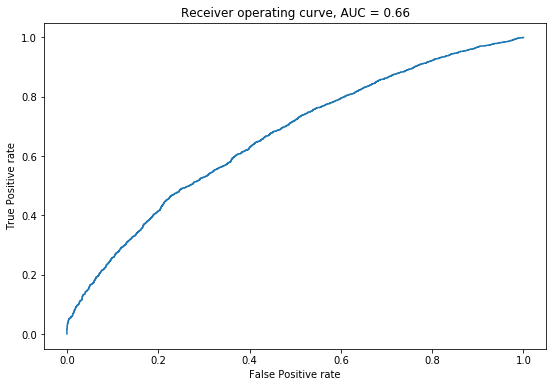

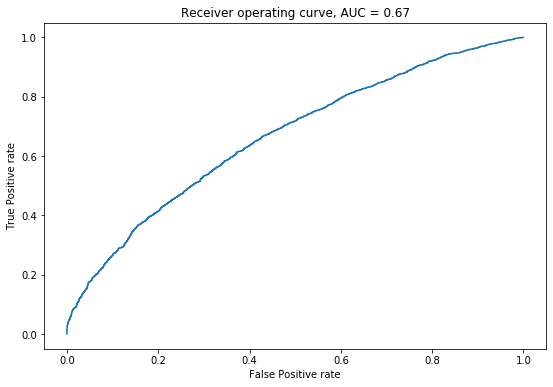

In [10]:
def plot_roc(pipeline):
    X_train, X_test, y_train, y_test = train_test_split(X_only_log_volume, y, test_size=.2, random_state=0)
    pipeline.fit(X_train, y_train)
    y_score = pipeline.predict_proba(X_test)
    fpr, tpr, thr = roc_curve(y_test, y_score[:, 1])
    auc = roc_auc_score(y_test, y_score[:, 1])

    plt.figure(figsize=(9, 6))
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive rate')
    plt.ylabel('True Positive rate')
    plt.title(f'Receiver operating curve, AUC = {auc:.2f}')
    
plot_roc(pipeline_logistic_regression_cv)
plot_roc(pipeline_bigger_nn)

In [11]:
pipeline_logistic_regression_cv_for_encoded_data = deepcopy(pipeline_logistic_regression_cv)
del pipeline_logistic_regression_cv_for_encoded_data.steps[0]
pipeline_logistic_regression_cv_for_encoded_data

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 LogisticRegressionCV(Cs=10, class_weight=None, cv=None,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=1000, multi_class='auto',
                                      n_jobs=None, penalty='l2',
                                      random_state=None, refit=True,
                                      scoring=None, solver='lbfgs', tol=0.0001,
                                      verbose=0))],
         verbose=False)

In [12]:
pipeline_bigger_nn_for_encoded_data = deepcopy(pipeline_bigger_nn)
del pipeline_bigger_nn_for_encoded_data.steps[0]
pipeline_bigger_nn_for_encoded_data

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=True, epsilon=1e-08,
                               hidden_layer_sizes=(40, 20),
                               learning_rate='adaptive',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=200, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)